These are the symbols that will be dropped:  ['id', 'member_id', 'term', 'int_rate', 'instalment', 'grade', 'sub_grade', 'employment_length', 'verification_status', 'issue_date', 'payment_plan', 'purpose', 'dti', 'delinq_2yrs', 'home_ownership', 'earliest_credit_line', 'inq_last_6mths', 'open_accounts', 'total_accounts', 'last_payment_date', 'last_credit_pull_date', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'annual_inc']
These are the remaining symbols:  ['loan_amount', 'funded_amount', 'funded_amount_inv', 'loan_status', 'out_prncp', 'out_prncp_inv', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_payment_amount']
These are the symbols that will be dropped:  ['id']
These are the remaining symbols:  ['member_id', 'loan_amount', 'funded_amount', 'funded_amount_inv', 'term', 'int_rate', 'instalment', 'grade', 'sub_grade', 'employment_length', 'home_ownership', 'annual_inc

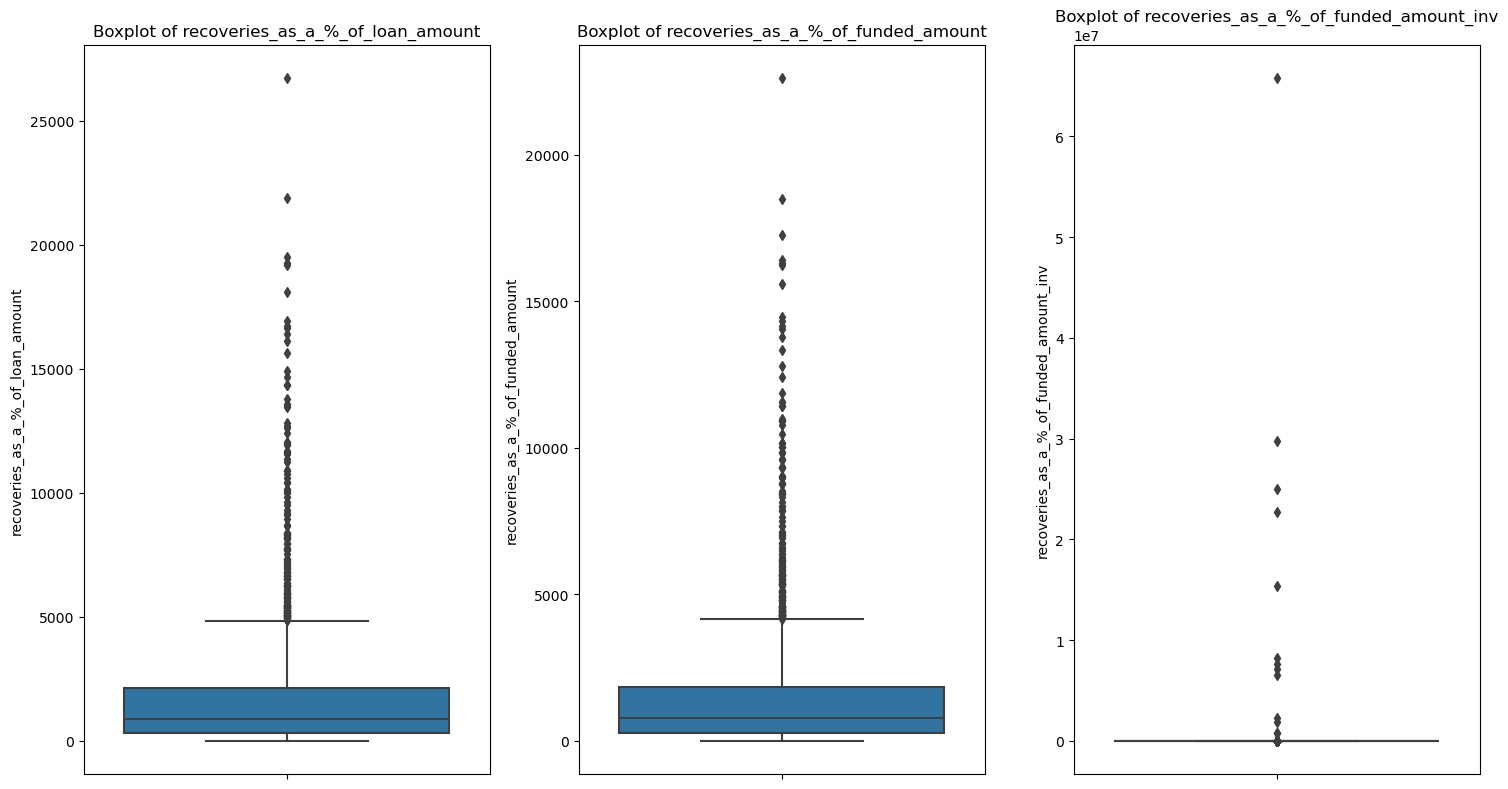

TypeError: DataFrameTransform.create_z_score_df() missing 1 required positional argument: 'self'

In [18]:
from RDSDatabaseConnector import RDSDatabaseConnector
from Plotter import Plotter
from DataTransform import DataTransform
from DataFrameTransform import DataFrameTransform
import pandas as pd

RDSD = RDSDatabaseConnector()
PL = Plotter()
DT = DataTransform()
DFT = DataFrameTransform
df = pd.read_csv('data2.csv')

all_columns = list(df.columns)
#print(all_columns)

def milestone4_task1(dataframe: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """Remove specific columns from a dataframe depending on which step you choose.

    Args:
        df (_type_): _description_
    """
    """Milestone 4 Task 1
    Step 1: Summarise currently what percentage of the loans are recovered against the investor 
            funding and the total amount funded. Visualise your results on an appropriate graph.
            
    Step 2: Additionally visualise what percentage of the total amount would be recovered up to
            6 months' in the future.
    """
    def step1_cleanup(dataframe, symbols):
        """Remove columns from the dataframe.

        Args:
            dataframe (_type_): _description_
            symbols (_type_): _description_

        Returns:
            _type_: _description_
        """
        dataframe = DT.excess_symbol_removal(dataframe, symbols)
        return dataframe
    symbols1 = ['id', 'member_id', 'term', 'int_rate', 'instalment', 'grade', 'sub_grade', 'employment_length']
    symbols2 = ['verification_status', 'issue_date', 'payment_plan', 'purpose', 'dti', 'delinq_2yrs', 'home_ownership']
    symbols3 = ['earliest_credit_line', 'inq_last_6mths', 'open_accounts', 'total_accounts',  'last_payment_date']
    symbols4 = ['last_credit_pull_date', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'annual_inc']
    symbols = symbols1 + symbols2 + symbols3 + symbols4
    step1_df_clean = step1_cleanup(dataframe, symbols)
    
    def step2_cleanup(df, symbols):
        df = DT.excess_symbol_removal(df, symbols)
        return df
    symbols = ['id']
    step2_df_clean = step2_cleanup(dataframe, symbols)
    
    return step1_df_clean, step2_df_clean
        
step1_df_clean, step2_df_clean = milestone4_task1(df)
#print(step1_df_clean)
#print(step2_df_clean)
'''GOALS
Summarise currently what percentage of the loans are recovered against the investor 
funding and the total amount funded. Visualise your results on an appropriate graph.

SO ((loans_recovered/investor_funding, loans_recovered/total_amount_funded)%)GRAPH

SO, columns which resemble these are loan_amount, funded_amount, funded_amount_inv,
    instalment, loan_status, out_prncp, out_prncp_inv, total_payment, total_rec_int,
    total_rec_late_fee, recoveries, collection_recovery_fee.

Additionally visualise what percentage of the total amount would be recovered up to
6 months' in the future.
'''

def create_recoveries_df(dataframe):
    """Create a dataframe from pandas series.

    Args:
        dataframe (_type_): _description_
    """
    def recoveries_divided_by(dataframe):
        """Create pandas series from dataframe.

        Args:
            dataframe (_type_): _description_

        Returns:
            _type_: _description_
        """
        recoveries_as_a_percentage_of_loan_amount: pd.Series = ((dataframe['recoveries']/dataframe['loan_amount'])*100)
        recoveries_as_a_percentage_of_funded_amount: pd.Series = ((dataframe['recoveries']/dataframe['funded_amount'])*100)
        recoveries_as_a_percentage_of_funded_amount_inv: pd.Series = ((dataframe['recoveries']/dataframe['funded_amount_inv'])*100)
        return recoveries_as_a_percentage_of_loan_amount, recoveries_as_a_percentage_of_funded_amount, recoveries_as_a_percentage_of_funded_amount_inv
    a, b, c = recoveries_divided_by(dataframe)
    recoveries_df = pd.DataFrame({'recoveries_as_a_%_of_loan_amount':a, 'recoveries_as_a_%_of_funded_amount':b, 'recoveries_as_a_%_of_funded_amount_inv':c})
    return recoveries_df

recoveries_df = create_recoveries_df(step1_df_clean)
recoveries_df = recoveries_df[(recoveries_df != 0).any(axis=1)]#remove rows where nothing is there on any of the columns
#print(recoveries_df)


PL.plot_boxplots(recoveries_df, ['recoveries_as_a_%_of_loan_amount', 'recoveries_as_a_%_of_funded_amount', 'recoveries_as_a_%_of_funded_amount_inv'])

recoveries_withzscore_df = DFT.create_z_score_df(df = recoveries_df, columns = (list(recoveries_df.columns)))
#print(recoveries_withzscore_df)
PL.plot_boxplots(recoveries_withzscore_df, ['recoveries_as_a_%_of_loan_amount', 'recoveries_as_a_%_of_funded_amount', 'recoveries_as_a_%_of_funded_amount_inv'])


recoveries_trimmed_df = DFT.trim_by_z_score(self = None, df = recoveries_withzscore_df, columns = list(recoveries_withzscore_df.columns))
PL.plot_boxplots(recoveries_trimmed_df, ['recoveries_as_a_%_of_loan_amount', 'recoveries_as_a_%_of_funded_amount', 'recoveries_as_a_%_of_funded_amount_inv'])






